# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend.

First, we load the data:

In [1]:
from copy import copy

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [3]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
# df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
# df_ercot.head()

In [4]:
# df_ercot.to_csv('/Users/alfonsogarciadecorral/Desktop/code/data/neuralprophet/ercot.csv', index=False)
df_ercot = pd.read_csv('/Users/alfonsogarciadecorral/Desktop/code/data/neuralprophet/ercot.csv')


We extract the name of the regions which will be later used in the model creation.

In [5]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [6]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[['ds', col]].copy(deep = True) #select column associated with region
    aux = aux.iloc[:26301, :].copy(deep = True) #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {col: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    aux['ID'] = col
    df_global = pd.concat((df_global,aux))
df_global = df_global.sort_values(by=['ID','ds']).reset_index(drop=True)

In [7]:
df_local = df_global[df_global['ID'] == 'EAST']
df_local = df_local[['ds','y']]
df_local.head()


ds       y
26301  2004-01-01 01:00:00  877.79
26302  2004-01-01 02:00:00  850.75
26303  2004-01-01 03:00:00  831.63
26304  2004-01-01 04:00:00  823.56
26305  2004-01-01 05:00:00  823.38

We will modify one time series trend and one time series seasonality

WARNING - (py.warnings._showwarnmsg) - /var/folders/g5/gjgtytcx0zb3tysnmlfdy0jr0000gn/T/ipykernel_18446/1195341361.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_global['y'] = np.where(df_global['ID']=='COAST', -df_global['y'], df_global['y'] )  + 2 * df_global[df_global['ID']=='COAST'].mean().y



<AxesSubplot:>

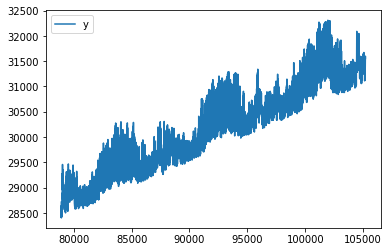

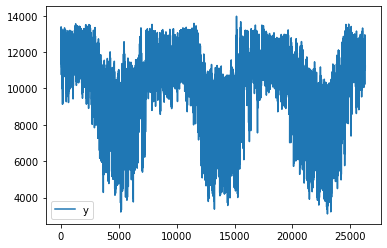

In [8]:
import numpy as np
df_global['y'] = np.where(df_global['ID']=='COAST', -df_global['y'], df_global['y'] )  + 2 * df_global[df_global['ID']=='COAST'].mean().y
df_global['y'] = np.where(df_global['ID']=='NORTH',df_global['y'] + .1*df_global.index, df_global['y'] )
df_global[df_global['ID']=='NORTH'].plot()

df_global[df_global['ID']=='COAST'].plot()


In [11]:
df_train, df_test = m.split_df(df_global, valid_p = 0.33, local_split = True)

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand. 

## Global-Local Modeling - Local Normalization

The default fitting of global models is based on local data normalization. Each time series will have data normalization parameters associated with each 'ID' provided. 

**Remarks:** 
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.
- Try different configurations of the trend: `trend_reg > 0`, `n_changepoints = 0`... Run `help(NeuralProphet)` or go to the official documentation for more information.

### LOCAL TREND 

In [57]:
m = NeuralProphet( 
    trend_global_local='local',
    season_global_local='global',
    n_lags=24,
    n_forecasts=17,
    epochs=3,
    trend_reg=1,
    quantiles=[0.1,0.9]
)

m.highlight_nth_step_ahead_of_each_forecast(3)



When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

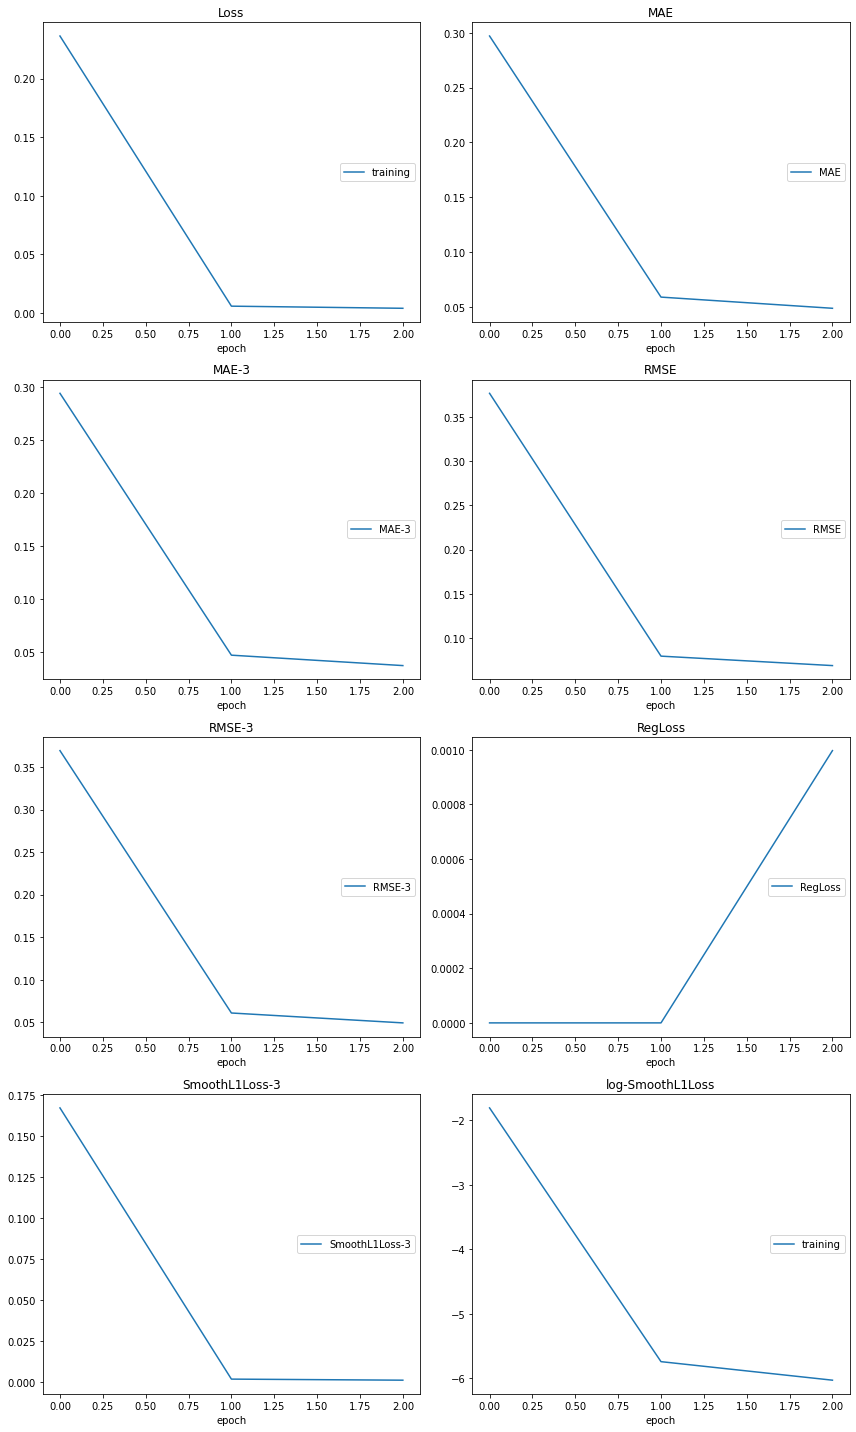

Loss
	training         	 (min:    0.004, max:    0.236, cur:    0.004)
MAE
	MAE              	 (min:    0.049, max:    0.297, cur:    0.049)
MAE-3
	MAE-3            	 (min:    0.037, max:    0.294, cur:    0.037)
RMSE
	RMSE             	 (min:    0.069, max:    0.377, cur:    0.069)
RMSE-3
	RMSE-3           	 (min:    0.049, max:    0.369, cur:    0.049)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.001, cur:    0.001)
SmoothL1Loss-3
	SmoothL1Loss-3   	 (min:    0.001, max:    0.167, cur:    0.001)
log-SmoothL1Loss
	training         	 (min:   -6.030, max:   -1.809, cur:   -6.030)


In [59]:
metrics = m.fit(df_train, freq = 'H', progress='plot-all')


Ensure you provide data identified with the keys associated with the appropriate train time series. Therefore, suitable normalization data parameters are used in post-fitting procedures (i.e., `predict`, `test`).

Please note that in the case of local normalization, the test metrics are not re-scaled but displayed on a normalized scale.

In [36]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)

COAST
EAST
FAR_WEST
NORTH
NORTH_C
SOUTHERN
SOUTH_C
WEST


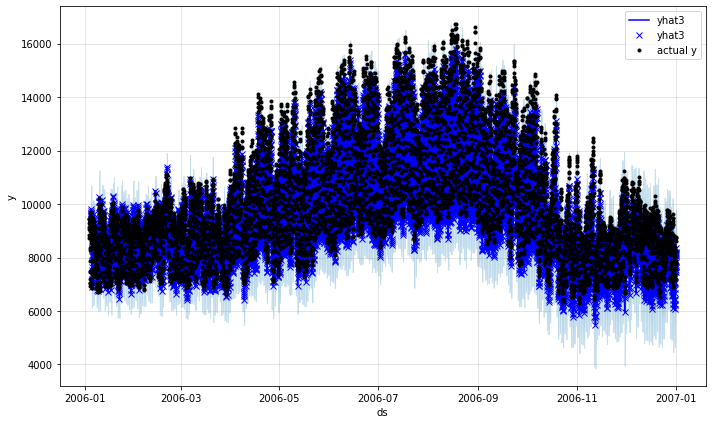

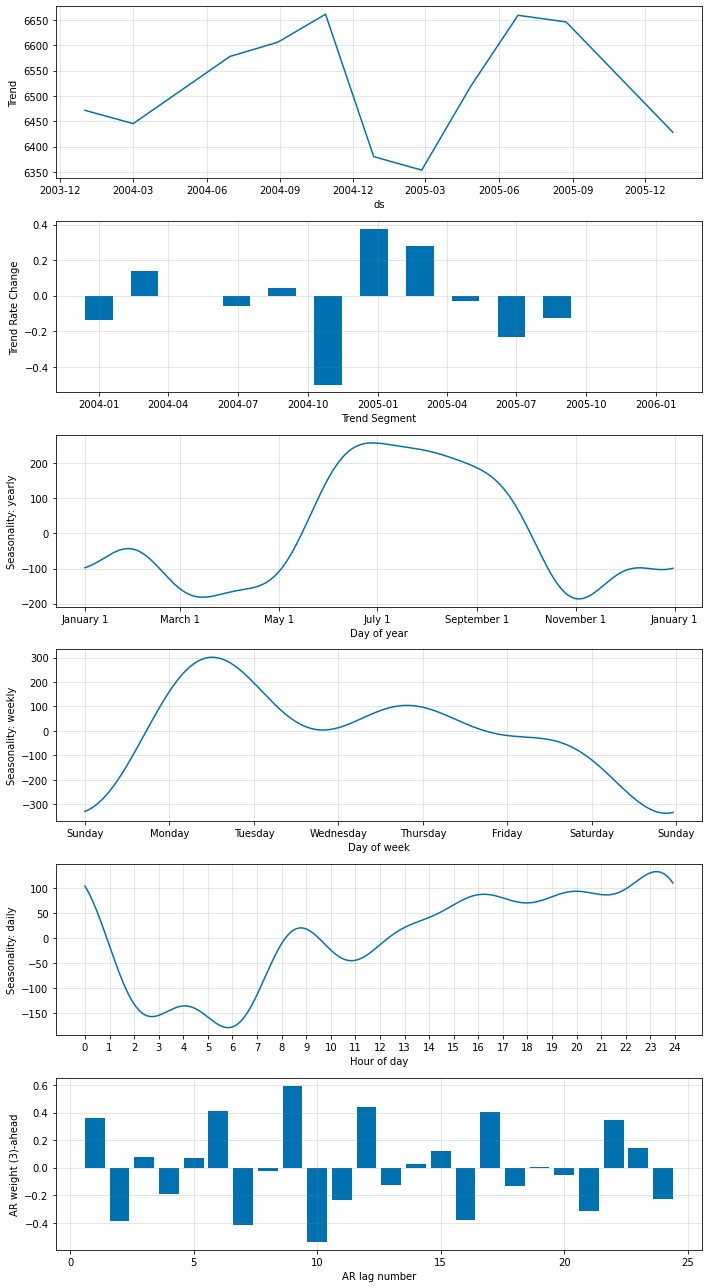

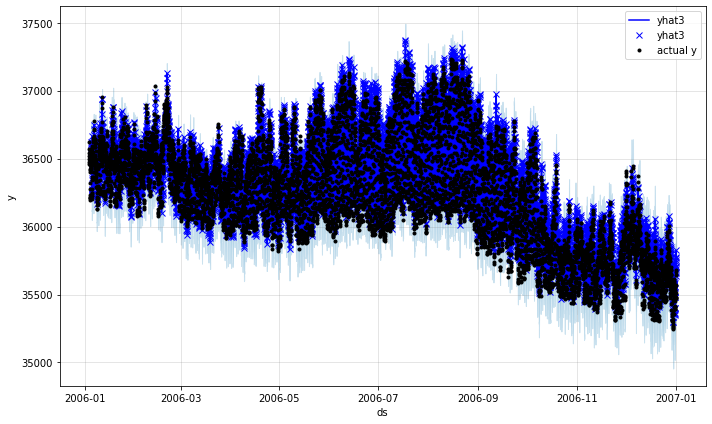

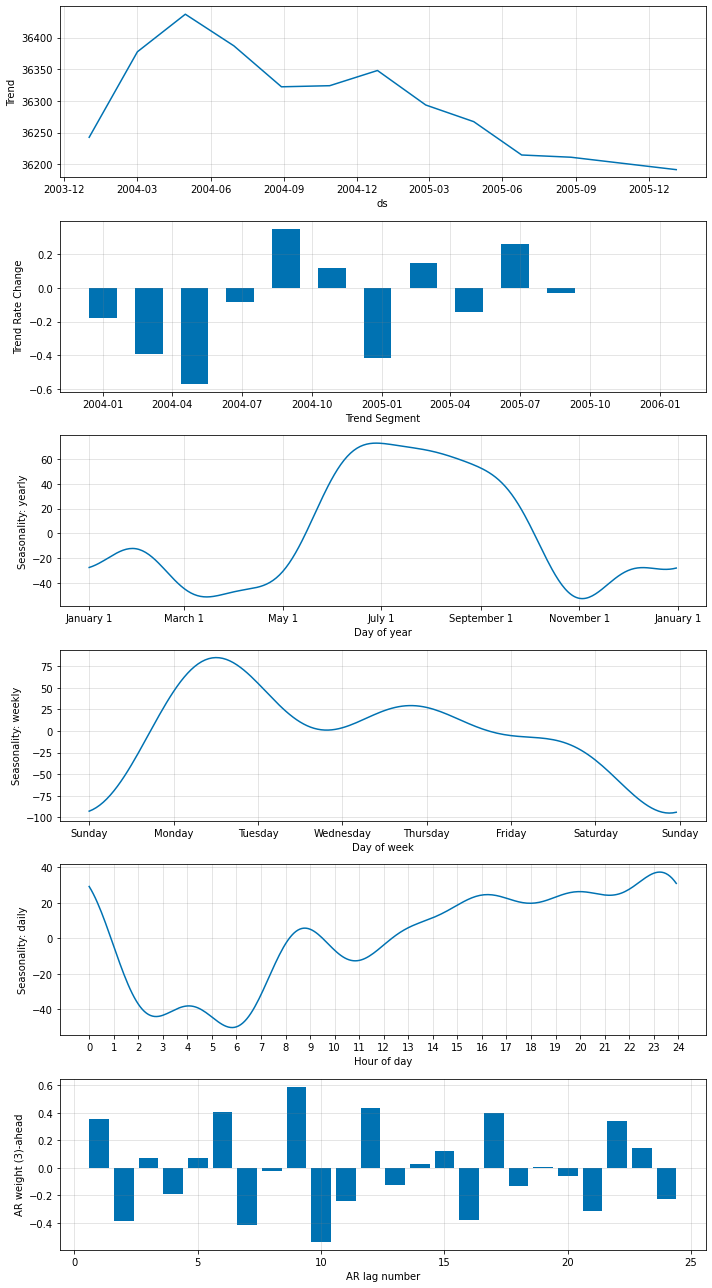

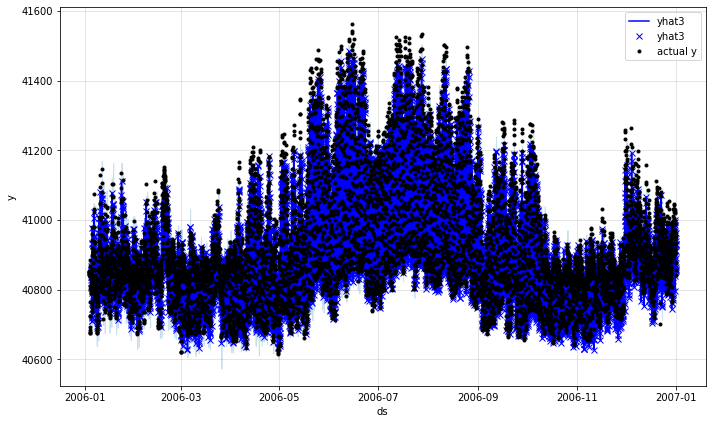

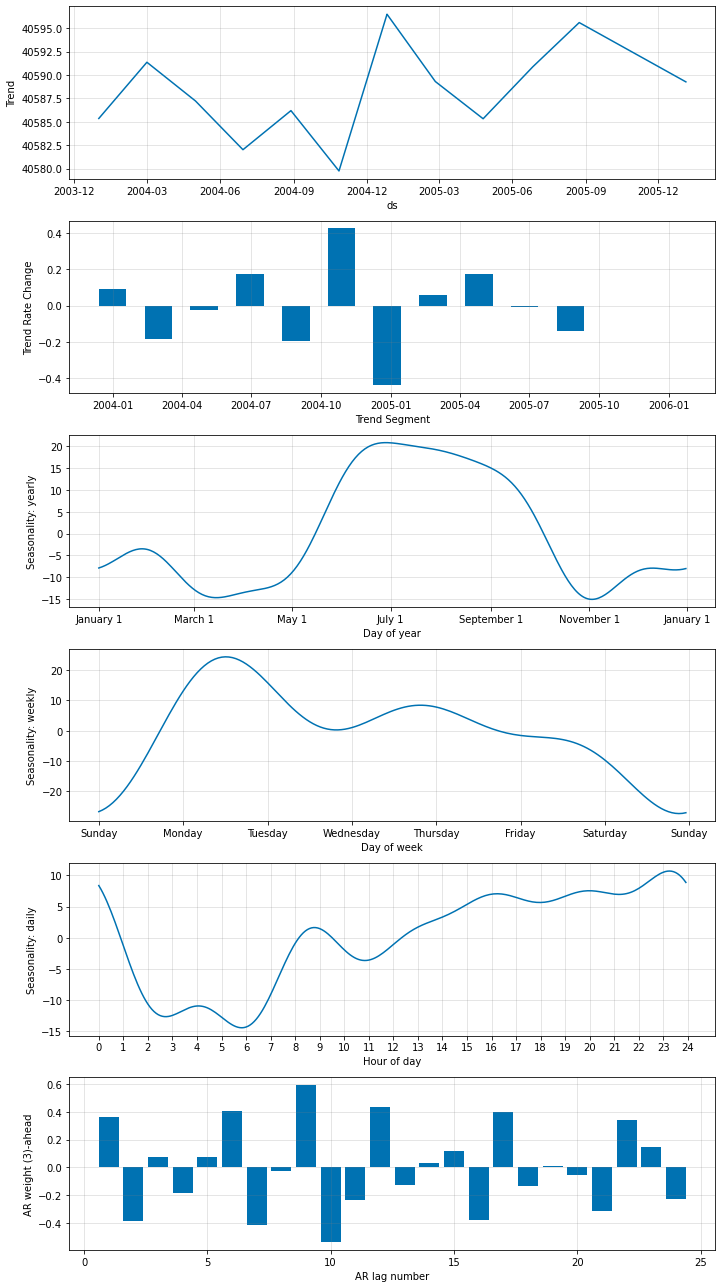

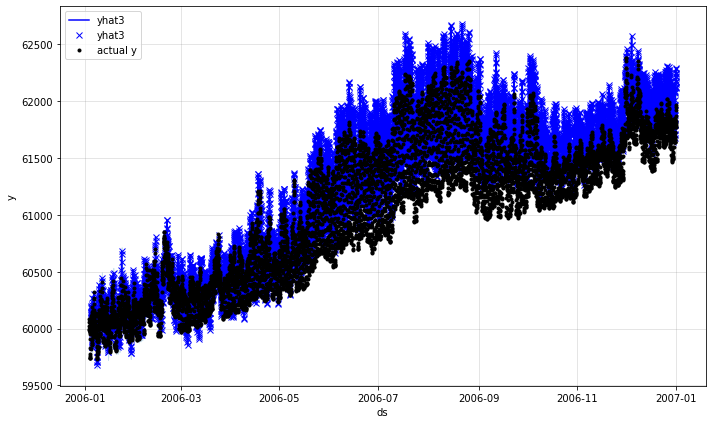

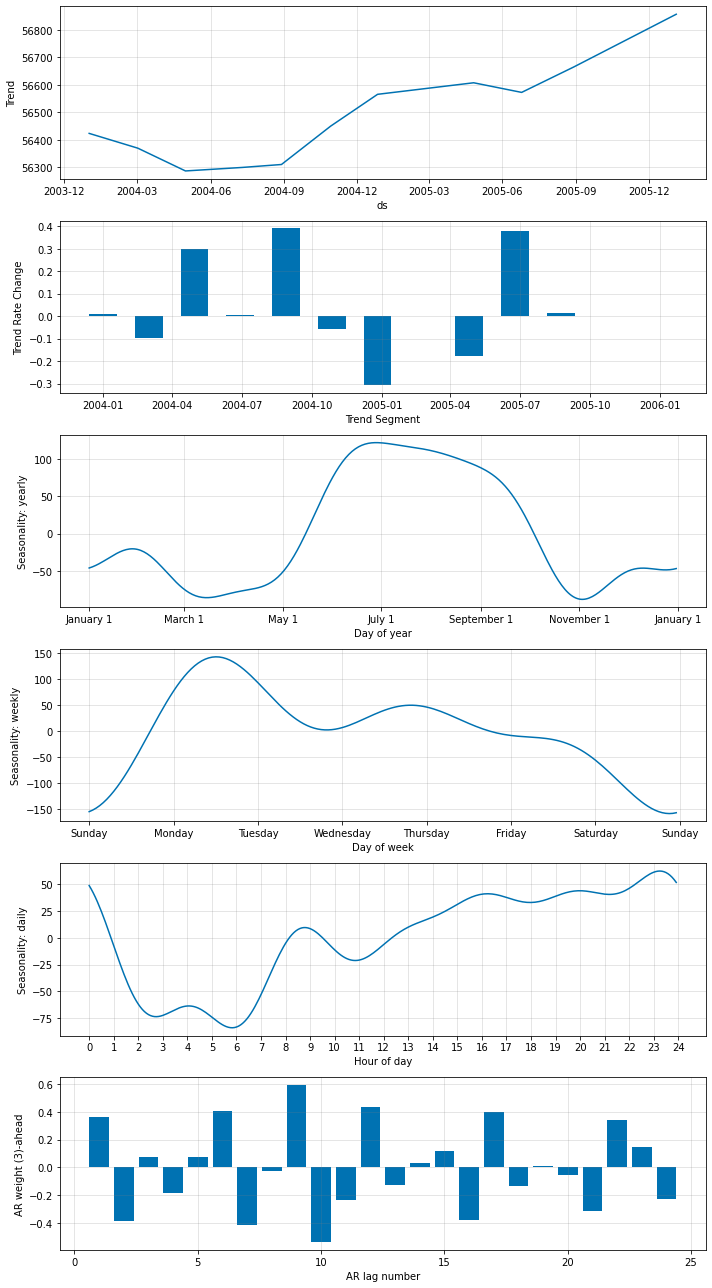

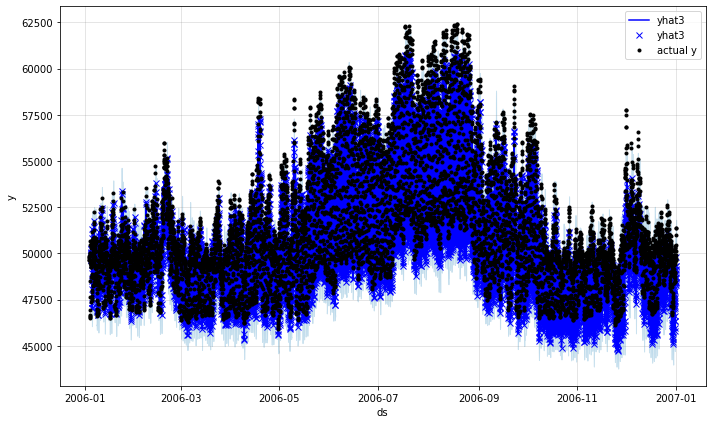

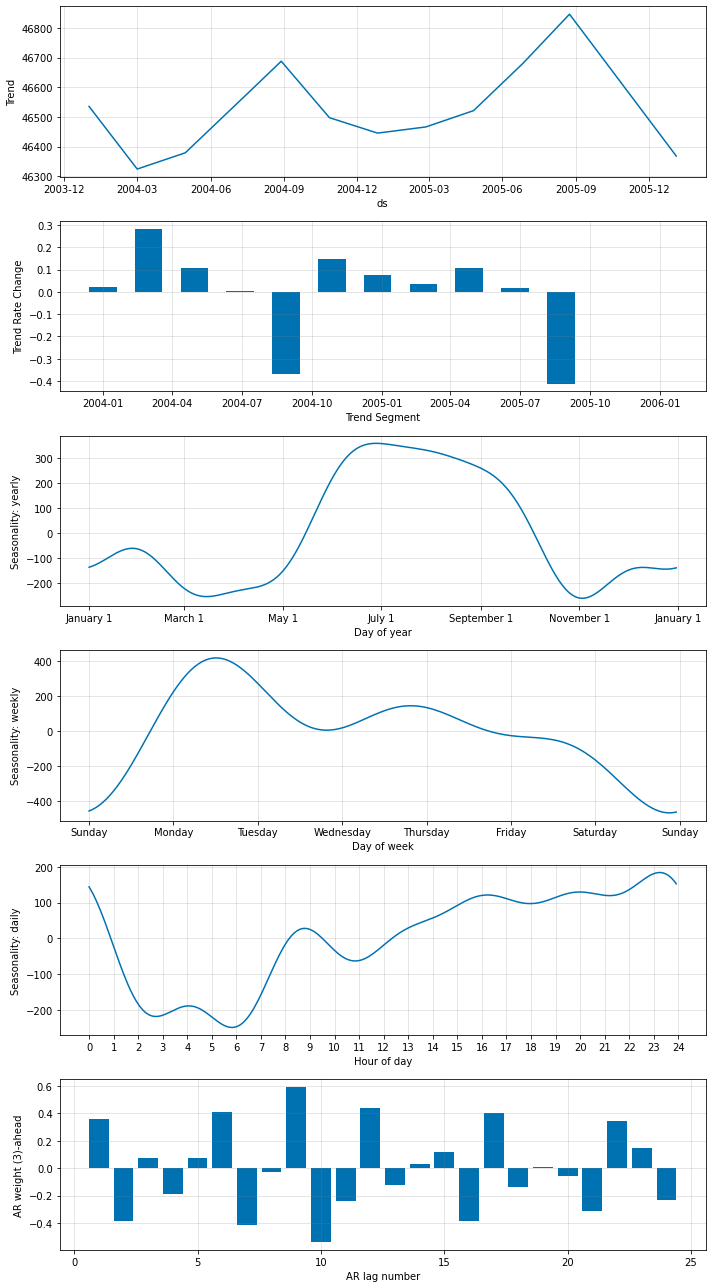

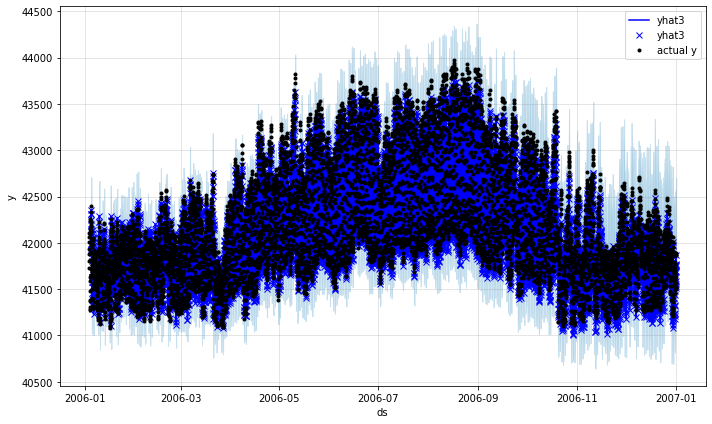

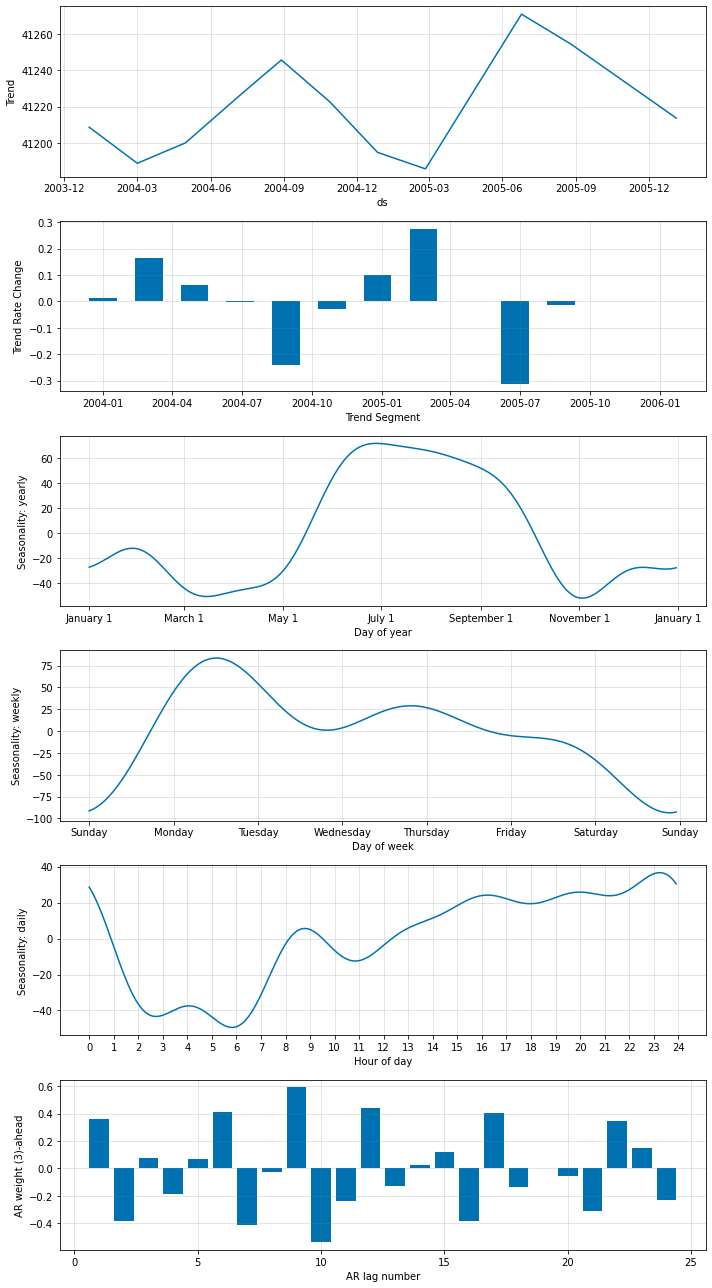

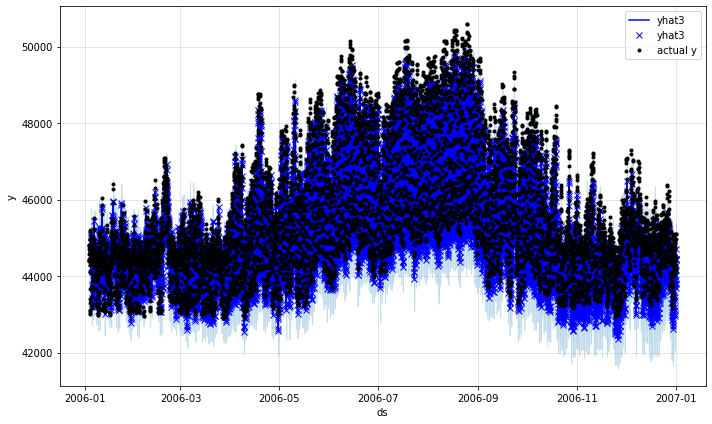

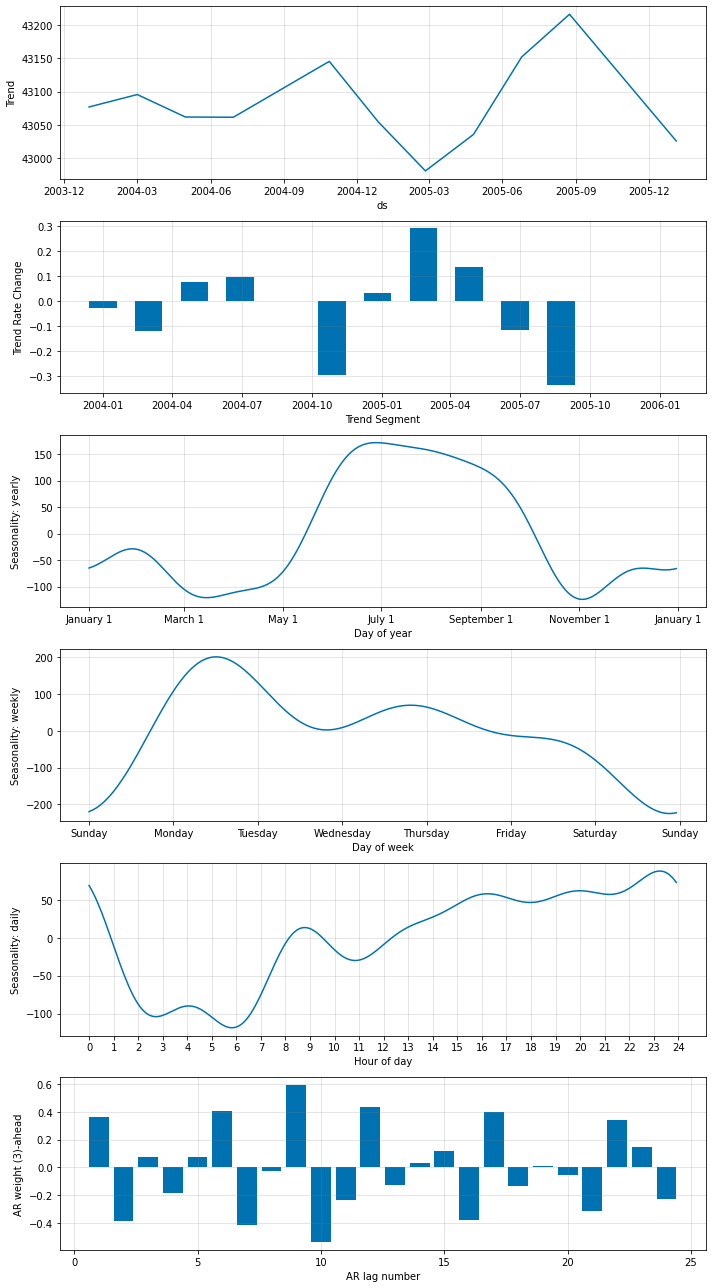

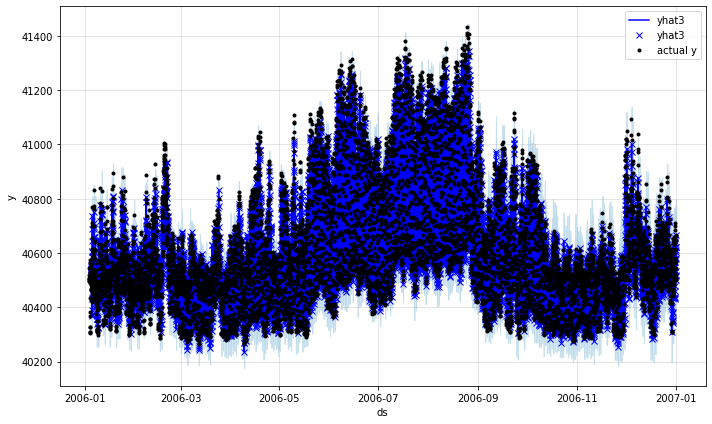

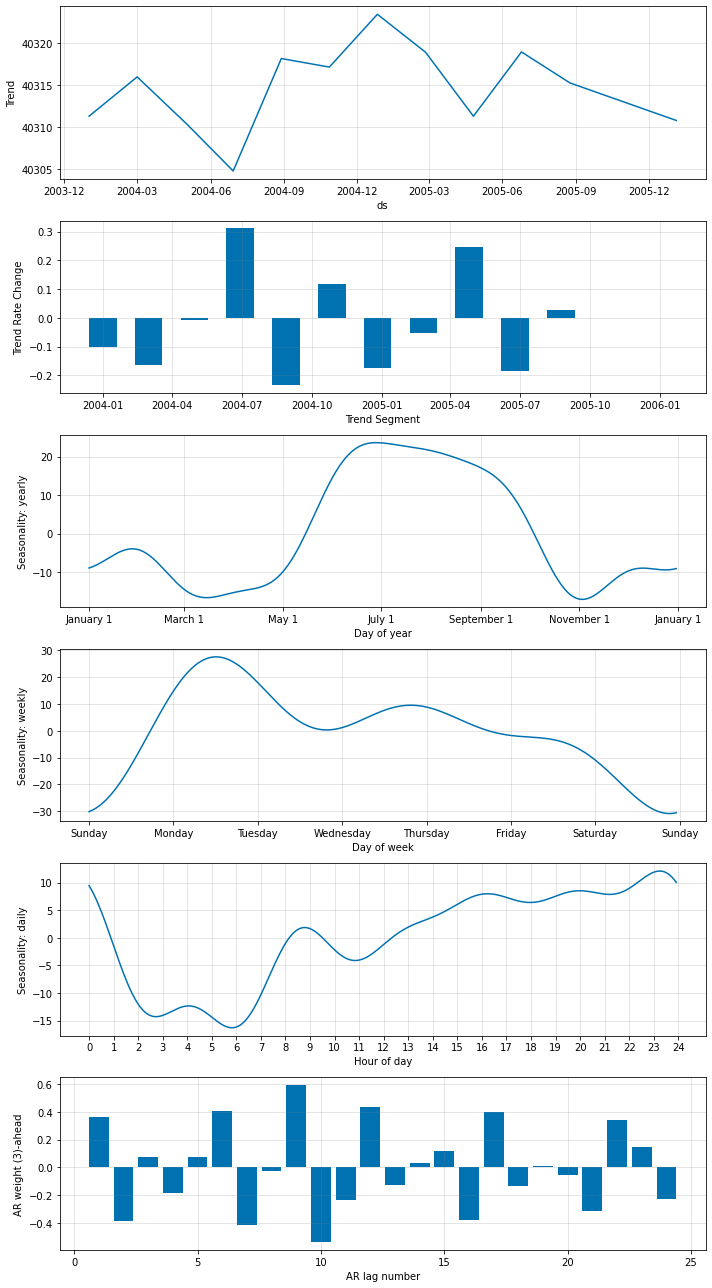

In [37]:
for i in regions:
    print(i)
    fig = m.plot(forecast[forecast['ID'] ==  i])
    fig_param = m.plot_parameters(df_name=i)

In [38]:
test_metrics = m.test(df_test)
test_metrics

SmoothL1Loss       MAE     RMSE  SmoothL1Loss-3     MAE-3    RMSE-3
0      0.004013  0.068529  0.08577        0.002832  0.060042  0.071915

### LOCAL SEASONALITY 

In [31]:
m = NeuralProphet( 
    trend_global_local='global',
    season_global_local='local',
    n_forecasts=17,
    learning_rate=0.1,
    epochs=3,
    quantiles=[0.1,0.9]
)




In [33]:
metrics = m.fit(df_train, freq = 'H')

In [ ]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)
for i in regions:
    fig = m.plot(forecast[forecast['ID'] ==  i])

In [28]:
test_metrics = m.test(df_test)
test_metrics

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /Users/alfonsogarciadecorral/Desktop/code/neural_prophet/env/lib/python3.8/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([864])) that is different to the input size (torch.Size([864, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



SmoothL1Loss       MAE      RMSE
0      0.084933  0.322906  0.377945

In [ ]:
fig_param = m.plot_parameters(df_name='COAST')

In [ ]:
fig_param = m.plot_parameters(df_name='NORTH')

### LOCAL TREND & SEASONALITY 

In [20]:
m = NeuralProphet(trend_global_local="local", season_global_local="local", epochs=5)

In [21]:
metrics = m.fit(df_train, freq = 'H')

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

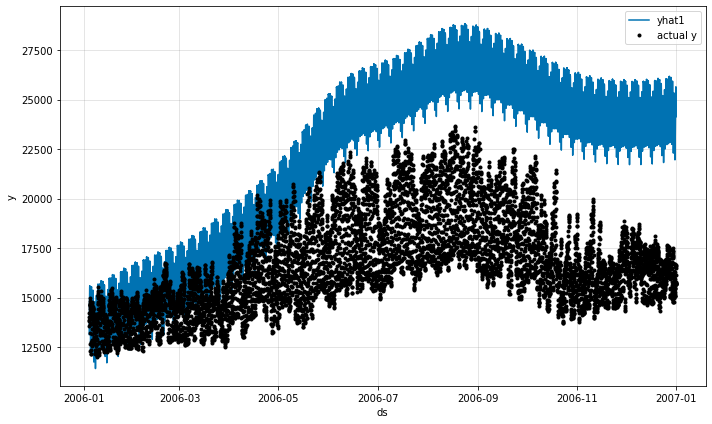

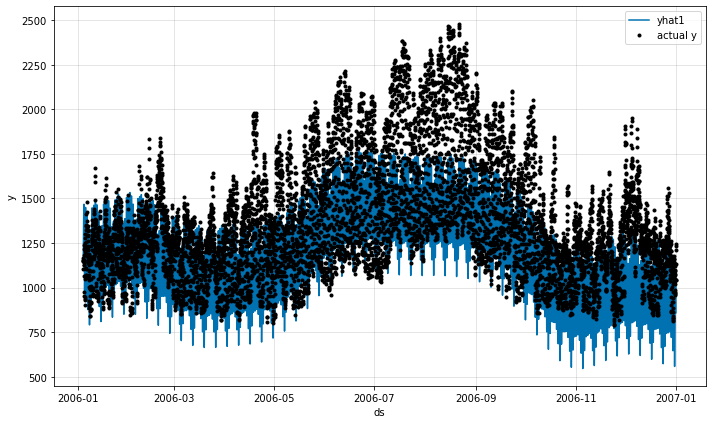

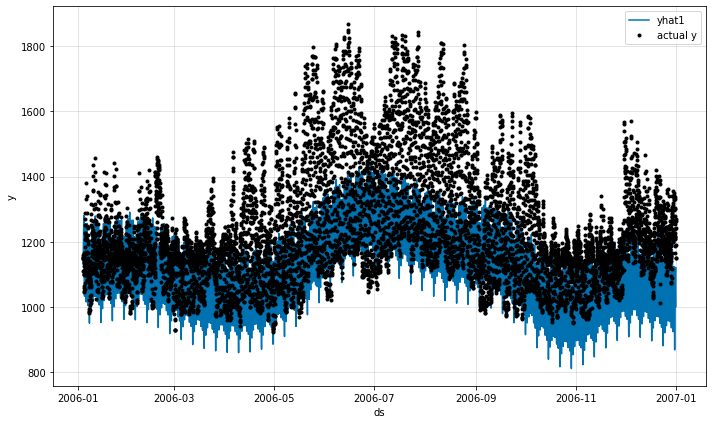

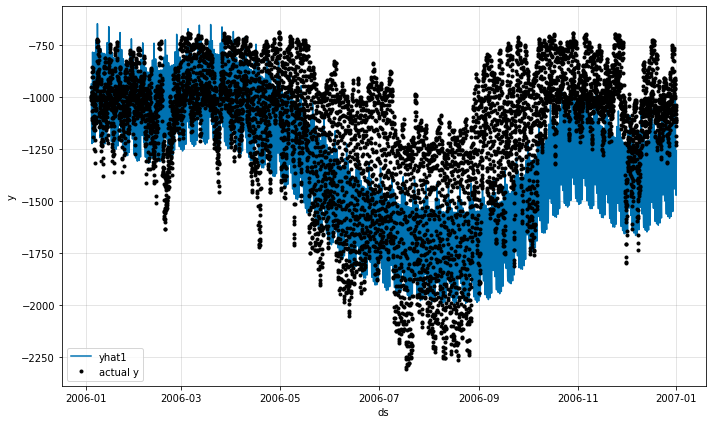

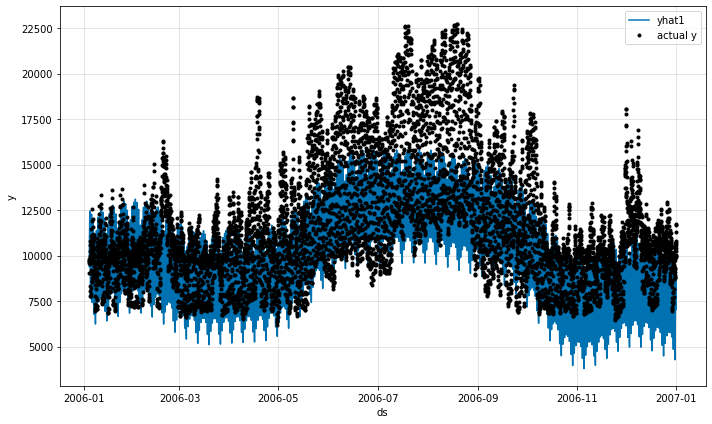

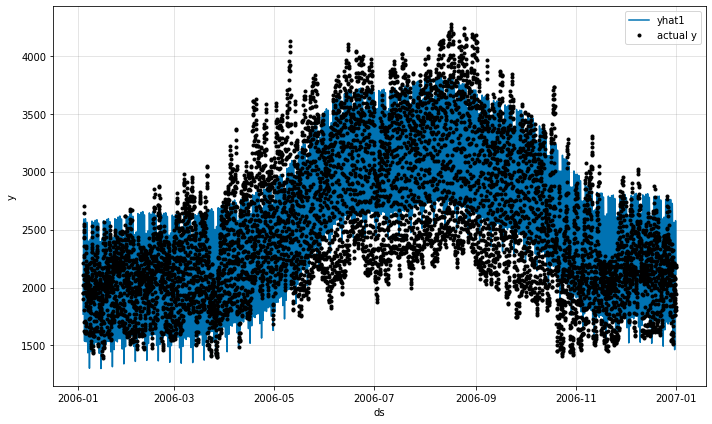

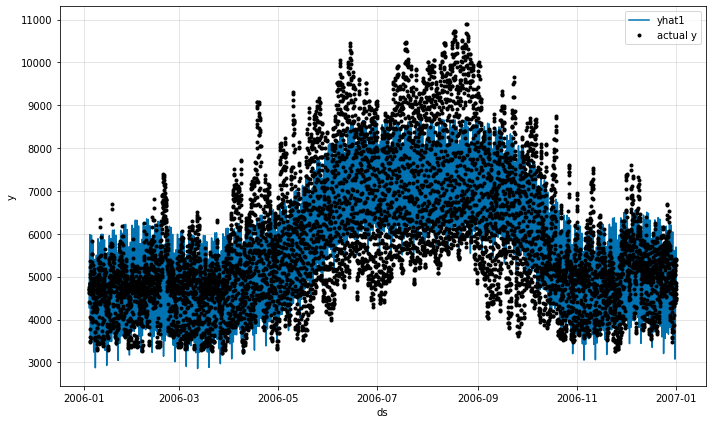

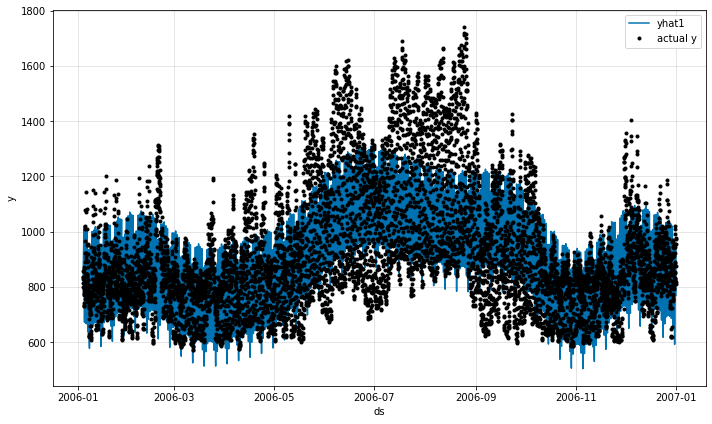

In [22]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)
for i in regions:
    fig = m.plot(forecast[forecast['ID'] ==  i])

In [23]:
test_metrics = m.test(df_test)
test_metrics

SmoothL1Loss       MAE      RMSE
0      0.037822  0.201251  0.236928

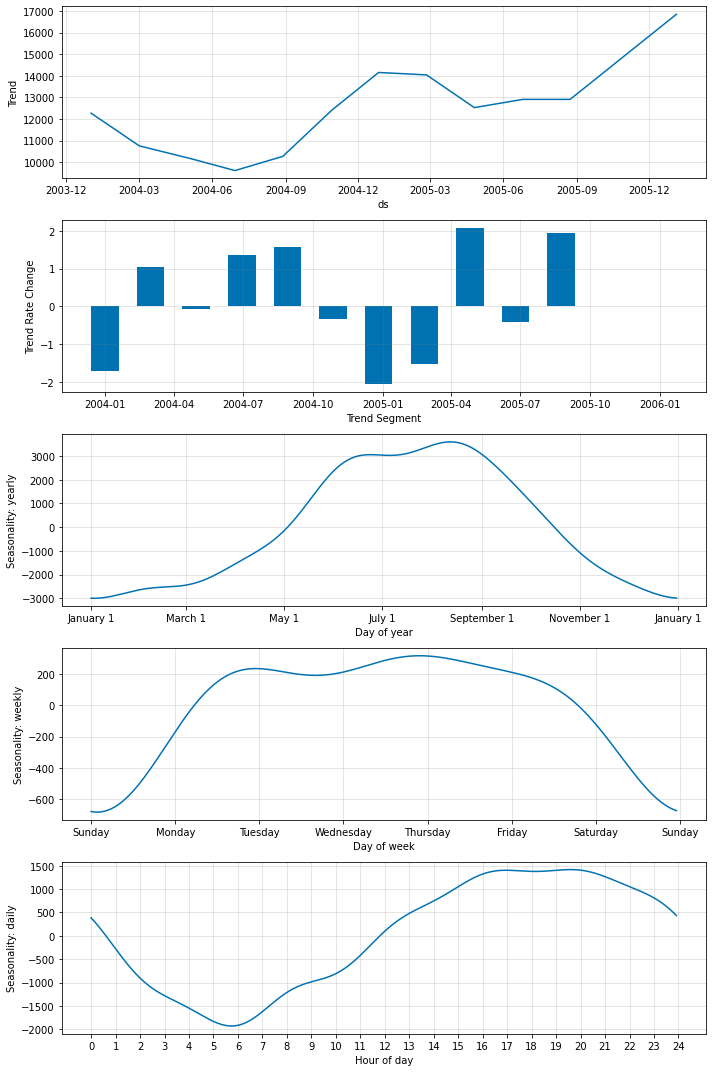

In [24]:
fig_param = m.plot_parameters(df_name='COAST')

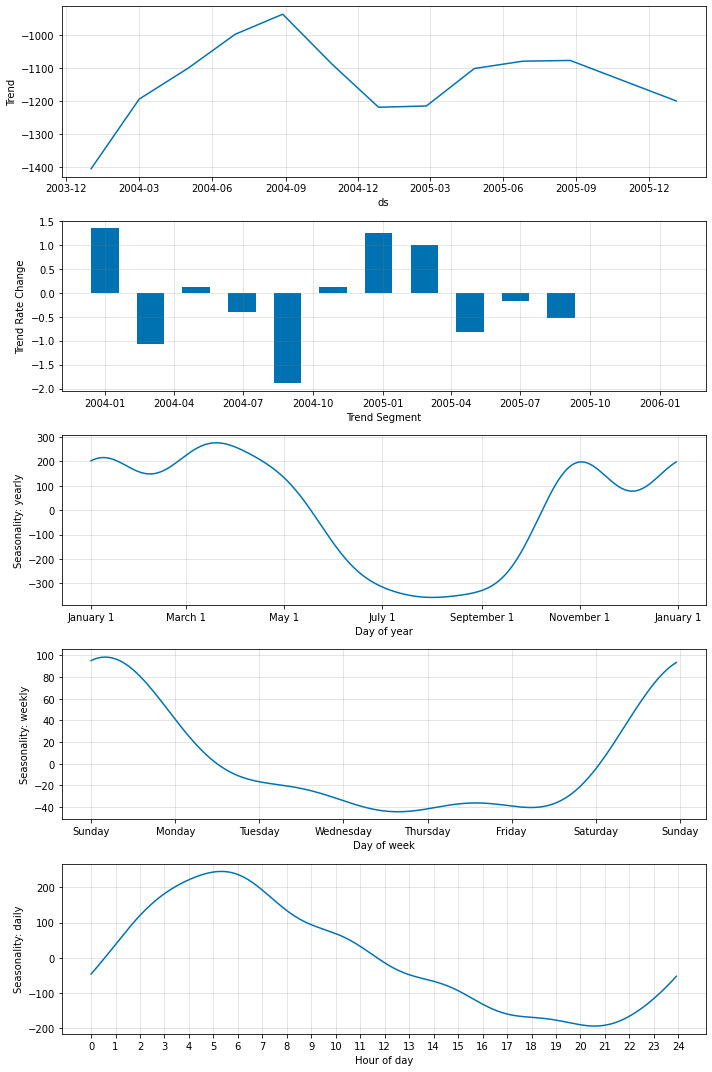

In [25]:
fig_param = m.plot_parameters(df_name='NORTH')